In [1]:
#Importamos librerias utiles
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

# Programar el algoritmo de retropropagacion

usando NumPy para una tarea de clasificación binaria presuponiendo una red densa con dos capas ocultas y la funcion de perdida de entropia cruzada binaria, entrena y evalua la red en algun conjunto de datos

In [2]:
#definimos la funcion de perdida entropia cruzada binaria
def EntropiaBinaria(y, p):
    p[p==0] = np.nextafter(0., 1.)
    p[p==1] = np.nextafter(1., 0.)
    return -(np.log(p[y==1]).sum() + np.log(1-p[y==0]).sum())

In [3]:
#Dado que se trata de clasificacion binaria y a todos nos gustan las funciones continuas y derivables
#para todo R, entonces usaremos la funcion de activacion sigmoide para todas las capas ocultas
def sigmoid(z):
    return 1/(1+np.exp(-z))
#definimos la derivada de la funcion sigmoide
def sigmoidDerivative(w):
    return np.multiply(sigmoid(w),(1-sigmoid(w)))

In [4]:
#Definimos nuestra metrica de exactitud
def exactitud(y, prediccion):
    return (y==prediccion).mean()*100

Dado que estamos restringidos a dos capas de ocultas, una de salida y una de entrada, nuestras ecuaciones de pesos y activaciones (propagacion hacia adelante) viene dado por:
$$\vec{a}^{(1)} = \vec{x}^{(i)}$$
$$\vec{z}^{(2)} = W^{(1)T} \cdot \vec{a}^{(1)} + \vec{b}^{(1)}$$
$$\vec{a}^{(2)} = \phi (\vec{z}^{(2)})$$
$$\vec{z}^{(3)} = W^{(2)T} \cdot \vec{a}^{(2)} + \vec{b}^{(2)}$$
$$\vec{a}^{(3)} = \phi (\vec{z}^{(3)})$$
$$\vec{z}^{(4)} = W^{(3)T} \cdot \vec{a}^{(3)} + \vec{b}^{(3)}$$
$$\vec{a}^{(4)} = \phi (\vec{z}^{(4)})$$
$$\hat{y}^{(i)} = a^{(4)}$$

Es decir tenemos tres matrices de pesos $W^{1,2,3}$ y tres vectores de sesgos $b^{1,2,3}$ una para cada capa respectivamente

In [5]:
#definimos la funcion de propagacion hacia adelante
def propagacion(x, w1, b1, w2, b2, w3, b3):
    #calculamos z2:
    z2 = (w1.T @ x[:,np.newaxis]) + b1
    #calculamos a2
    a2 = sigmoid(z2)
    #calculamos z3
    z3 = (w2.T @ a2) + b2
    #calculamos a3
    a3 = sigmoid(z3)
    #calculamos z4
    z4 = (w3.T @ a3) + b3
    #hacemos la prediccion (obtenemos a4)
    prediccion = sigmoid(z4)
    #regresamos los valores que acabamos de calcular
    return z2, a2, z3, a3, z4, prediccion

Nuevamente para entrenar hay que calcular el error de la funcion de perdida (costo) esto se hace por el descenso del gradiente, las reglas de actualizacion del mismo definidas en la libreta de teoria y el algoritmo de retropropagacion

In [6]:
#definimos nuestro algoritmo de retropropagacion
def retropropagacion(x, y, learningRate, epochs, neuronasOcultas):
    ejemplos = x.shape[0]
    entradas = x.shape[1]
    #inicializamos los pesos W y b de forma aleatoria
    W1 = np.sqrt(1.0 / entradas) * np.random.randn(entradas, neuronasOcultas)
    b1 = np.zeros((neuronasOcultas, 1))
    W2 = np.sqrt(1.0 / neuronasOcultas) * np.random.randn(neuronasOcultas, 1)
    b2 = np.zeros((neuronasOcultas, 1))
    W3 = np.sqrt(1.0 / neuronasOcultas) * np.random.randn(neuronasOcultas, 1)
    b3 = np.zeros((1, 1))
    #definimos el vector de perdidas, que en cada epoca se va a actualizar
    perdidas = np.zeros((epochs))
    #definimos el vector de exactitudes que en cada epoca se ca a actualizar
    exactitudes = np.zeros((epochs))
    #definimos el vector de predicciones que corresponde al numero de salidas
    predicciones = np.zeros((y.shape))
    #iteramos sobre las epocas
    for epoch in range(epochs):
        #iteramos sobre todos los ejemplos de entrenamiento
        for ejemplo in range(ejemplos):
            #calculamos los vectores resultantes de la propagacion
            z2, a2, z3, a3, z4, prediccion = propagacion(x[ejemplo], W1, b1, W2, b2, W3, b3)
            #algoritmo de retropropagacion:
            #3) calcula el error de la capa de salida (punto 3 del notebook de teoria)
            # gradiente de C en la direccion de a producto de haramad
            #con la derivada de la funcion de activacion evaluada en z^{L}
            #gradUltimaCapa = prediccion - y[ejemplo]
            gradUltimaCapa = prediccion - y[ejemplo]
            #gradientes de la funcion de perdida con respecto a w y b en la ultima capa
            W3actual = np.outer(a3, gradUltimaCapa)
            b3actual = gradUltimaCapa
            #4.1) retropropaga el error al calcular d^{l} con l=L-1, L-2 ,..., 2
            #para este caso l = 3
            gradCapa2 = np.multiply((W3 @ gradUltimaCapa), sigmoidDerivative(z3))
            #gradientes de la funcion de perdida con respecto a w y b en la penultima capa
            W2actual = np.outer(a2, gradCapa2)
            b2actual = gradCapa2
            # 4.2) retropropaga el error al calcular d^{l} con l=L-1, L-2 ,..., 2
            #para este caso l = 2
            gradCapa1 = np.multiply((W2.T @ gradCapa2), sigmoidDerivative(z2))
            #gradientes de la funcion de perdida con respecto a w y b en la primera capa
            W1actual = np.outer(x[ejemplo], gradCapa1)
            b1actual = gradCapa1
            ##Actualizamos los pesos para la siguiente epoca
            W3 = W3 - learningRate * W3actual
            b3 = b3 - learningRate * b3actual
            W2 = W2 - learningRate * W2actual
            b2 = b2 - learningRate * b2actual
            W1 = W1 - learningRate * W1actual
            b1 = b1 - learningRate * b1actual
            ##Fin de la retropropagacion
            #asignamos nuestra prediccion
            predicciones[ejemplo] = prediccion
        #calculamos la perdida para la epoca actual
        perdidas[epoch] = EntropiaBinaria(y, predicciones)
        #calculamos las exactitudes para la epoca actual
        exactitudes[epoch] = exactitud(y, np.round(predicciones))
        #imprimimos la perdida y la exactitud para la epoca actual
        print('Epoch {0}: Perdida = {1} Exactitud = {2}'.format(epoch,perdidas[epoch],exactitudes[epoch]))
    return W1, W2, W3, b1, b2, b3, perdidas, exactitudes

Entrenemos nuestra red con el mismo XNOR de la libreta pasada

In [7]:
#definimos las entradas
x = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
#definimos las salidas
y = np.array([[1, 0, 0, 1]]).T
#Para reproducibilidad ponemos una semilla
np.random.seed(2020)
#entrenamos la red
#W1, W2, W3, b1, b2, b3, perdidas, exactitudes = retropropagacion(x,y,epochs=2000,learningRate=0.1,neuronasOcultas=7)
W1, W2, W3, b1, b2, b3, perdidas, exactitudes = retropropagacion(x,y,epochs=990,learningRate=0.31,neuronasOcultas=28)

Epoch 0: Perdida = 4.012377961041257 Exactitud = 50.0
Epoch 1: Perdida = 3.933504592256437 Exactitud = 50.0
Epoch 2: Perdida = 3.8531135884405607 Exactitud = 50.0
Epoch 3: Perdida = 3.7801575165004175 Exactitud = 50.0
Epoch 4: Perdida = 3.715160017104852 Exactitud = 50.0
Epoch 5: Perdida = 3.657368028747335 Exactitud = 50.0
Epoch 6: Perdida = 3.605943802898431 Exactitud = 50.0
Epoch 7: Perdida = 3.5601012351157406 Exactitud = 50.0
Epoch 8: Perdida = 3.5191324594621927 Exactitud = 50.0
Epoch 9: Perdida = 3.4824130576951235 Exactitud = 25.0
Epoch 10: Perdida = 3.44939900669913 Exactitud = 25.0
Epoch 11: Perdida = 3.4196198480260134 Exactitud = 25.0
Epoch 12: Perdida = 3.3926704222049753 Exactitud = 25.0
Epoch 13: Perdida = 3.3682024521600864 Exactitud = 25.0
Epoch 14: Perdida = 3.345916635296761 Exactitud = 25.0
Epoch 15: Perdida = 3.32555553731958 Exactitud = 25.0
Epoch 16: Perdida = 3.306897374904687 Exactitud = 25.0
Epoch 17: Perdida = 3.289750665599265 Exactitud = 25.0
Epoch 18: Perd

Epoch 339: Perdida = 2.9131524350097218 Exactitud = 50.0
Epoch 340: Perdida = 2.912758916527281 Exactitud = 50.0
Epoch 341: Perdida = 2.912361836209114 Exactitud = 50.0
Epoch 342: Perdida = 2.911961143212655 Exactitud = 50.0
Epoch 343: Perdida = 2.9115567861634553 Exactitud = 50.0
Epoch 344: Perdida = 2.9111487131498714 Exactitud = 50.0
Epoch 345: Perdida = 2.9107368717178126 Exactitud = 50.0
Epoch 346: Perdida = 2.9103212088655708 Exactitud = 50.0
Epoch 347: Perdida = 2.90990167103872 Exactitud = 50.0
Epoch 348: Perdida = 2.909478204125099 Exactitud = 50.0
Epoch 349: Perdida = 2.9090507534498817 Exactitud = 50.0
Epoch 350: Perdida = 2.9086192637707438 Exactitud = 50.0
Epoch 351: Perdida = 2.908183679273119 Exactitud = 50.0
Epoch 352: Perdida = 2.9077439435655648 Exactitud = 50.0
Epoch 353: Perdida = 2.907299999675238 Exactitud = 50.0
Epoch 354: Perdida = 2.9068517900434783 Exactitud = 50.0
Epoch 355: Perdida = 2.9063992565215235 Exactitud = 50.0
Epoch 356: Perdida = 2.9059423403663436

Epoch 713: Perdida = 2.2756684107045952 Exactitud = 75.0
Epoch 714: Perdida = 2.274135556177751 Exactitud = 75.0
Epoch 715: Perdida = 2.272612447561831 Exactitud = 75.0
Epoch 716: Perdida = 2.271099010196084 Exactitud = 75.0
Epoch 717: Perdida = 2.269595168029226 Exactitud = 75.0
Epoch 718: Perdida = 2.2681008436183525 Exactitud = 75.0
Epoch 719: Perdida = 2.2666159581255543 Exactitud = 75.0
Epoch 720: Perdida = 2.265140431312142 Exactitud = 75.0
Epoch 721: Perdida = 2.2636741815303862 Exactitud = 75.0
Epoch 722: Perdida = 2.262217125712684 Exactitud = 75.0
Epoch 723: Perdida = 2.260769179358024 Exactitud = 75.0
Epoch 724: Perdida = 2.259330256515669 Exactitud = 75.0
Epoch 725: Perdida = 2.257900269765923 Exactitud = 75.0
Epoch 726: Perdida = 2.2564791301978673 Exactitud = 75.0
Epoch 727: Perdida = 2.255066747383933 Exactitud = 75.0
Epoch 728: Perdida = 2.253663029351191 Exactitud = 75.0
Epoch 729: Perdida = 2.252267882549199 Exactitud = 75.0
Epoch 730: Perdida = 2.250881211814273 Exac

In [8]:
print('Con los hiperparametros de 1500 epocas, LR de 0.5 y 14 neuronas ocultas se encuentra una exactitud de 100')
print('Para dichos hiperparametros tenemos que')
print('Matriz de pesos w1')
print(W1)
print('############################################################')
print('vector de sesgos b1')
print(b1)
print('############################################################')
print('Matriz de pesos w2')
print(W2)
print('############################################################')
print('vector de sesgos b2')
print(b2)
print('############################################################')
print('Matriz de pesos w3')
print(W3)
print('############################################################')
print('vector de sesgos b3')
print(b3)
print('############################################################')

Con los hiperparametros de 1500 epocas, LR de 0.5 y 14 neuronas ocultas se encuentra una exactitud de 100
Para dichos hiperparametros tenemos que
Matriz de pesos w1
[[-2.1902591  -1.50348565 -2.0495746  -1.72902074 -1.57200335 -1.9812059
  -1.59777367 -1.32521613 -1.30583964 -1.70438743 -1.86290405 -0.68895591
  -0.71533301 -2.14226383 -1.25400759 -2.05945435 -1.66635836 -1.82583265
  -1.2457046  -1.41271659 -0.21782808 -1.43890359 -1.53622413 -1.76009357
  -1.86346787 -1.99424411 -1.82213066 -2.21473858]
 [ 1.40231032  1.67059232  2.16929059  1.65415312  1.28977512  0.80567461
   1.83569276  1.01427259  1.36941674  1.31021488  1.71594041  1.80280451
   0.82577178 -0.41526595 -0.15090673  1.26259564 -0.0723132   1.60912229
   1.06673246  1.16059036  1.03467993  1.27278046  1.55985211  1.75503843
   2.63271361  0.62234417  1.17797151  2.17611276]]
############################################################
vector de sesgos b1
[[ 0.08374923]
 [-0.42918795]
 [-0.19359224]
 [-0.24201148]


In [9]:
y_xnor = np.array([1., 0., 0., 1.])
print('-----------------------------')
print('x_1 \tx_2 \ty\tprediccion')
print('-----------------------------')
for i in range(x.shape[0]):
    #calculamos la prediccion usando las W's y las b's con la funcion de propagacion
    #los valores de a2, z2 y z3 no se usan por eso tienen el nombre de foo
    foo1, foo2, foo3, foo4, foo5, prediccionDespuesdeEntrenar = propagacion(x[i],W1,b1,W2,b2, W3, b3)
    print('{0}\t{1}\t{2}\t{3}'.format(x[i, 0], x[i, 1], y_xnor[i], np.round(prediccionDespuesdeEntrenar[0][0])))

-----------------------------
x_1 	x_2 	y	prediccion
-----------------------------
0	0	1.0	1.0
0	1	0.0	0.0
1	0	0.0	0.0
1	1	1.0	1.0


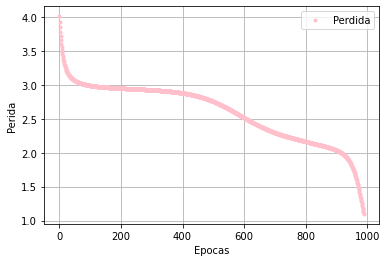

In [10]:
#graficamos la perdida
plt.plot(np.arange(perdidas.size), perdidas, '.', label='Perdida', color = 'pink')
plt.legend()
plt.xlabel('Epocas')
plt.ylabel('Perida')
plt.grid(True)
plt.show()

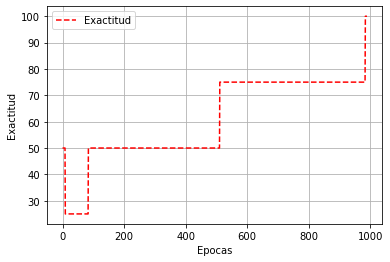

In [11]:
#graficamos la exactitud
plt.plot(np.arange(exactitudes.size), exactitudes, '--', label='Exactitud', color='red')
plt.legend()
plt.xlabel('Epocas')
plt.ylabel('Exactitud')
plt.grid(True)
plt.show()

## Entrenemos ahora con un data set no tan de juguete

### Data set IRIS de jueguete pero no tanto

In [12]:
#hacemos uso de sklearn para importar los datos de iris
from sklearn import datasets
#generamos las clases que vamos a estudiar usamos una semilla para reproducibilidad
np.random.seed(2020)
# sean 0 = 'setosa', 1 = 'versicolor', 2 ='virginica'
print(np.random.choice(3,2, replace=False))
#elegimos las clases versicolor y virginica :)
#cargamos los datos
iris = datasets.load_iris()

[1 2]


In [13]:
#definimos nuestras etiquetas, como solo consideramos dos clases hay que recortar el dataset
y = iris.target[50:,np.newaxis]
#definimos nuestros datos de entrenamiento, igual hay que recortar el dataset
x = iris.data[50:,:]

In [14]:
np.random.seed(2020)
#juntamos los datos para poder hacer un shuffle
data = np.concatenate((x,y),axis=1)
#shufleamos los datos dos veces
np.random.shuffle(data)
np.random.shuffle(data)

In [15]:
#vamos a definir un conjunto de entrenamiento y otro de validacion, como ya estan shufleados
#solo basta con escoger los primeros 80 datos como entrenamiento y el restante como validacion
# 80% test 20% val
x_train = data[:80,:4]
y_train = data[:80,-1]
y_train = y_train[:,np.newaxis]
x_test = data[80:,:4]
y_test = data[80:,-1]

In [16]:
#cambiamos todos aquellos valores de y que sean 2 por 0 esto para que el problema sea realmente binario
y_train[np.where(y_train == 2)] = 0
y_test[np.where(y_test == 2)] = 0

In [17]:
#comprobamos que lo anterior se hizo correctamente
y_test

array([1., 0., 0., 1., 1., 0., 1., 1., 0., 1., 1., 0., 1., 1., 0., 1., 1.,
       0., 1., 0.])

In [18]:
## amos a entrenar
np.random.seed(2055)
W1, W2, W3, b1, b2, b3, perdidas, exactitudes = retropropagacion(x_train,y_train,epochs=110,learningRate=0.1,neuronasOcultas=14)

Epoch 0: Perdida = 57.32150677368457 Exactitud = 48.75
Epoch 1: Perdida = 57.167473332652825 Exactitud = 45.0
Epoch 2: Perdida = 57.10087230370146 Exactitud = 45.0
Epoch 3: Perdida = 57.03032226120676 Exactitud = 46.25
Epoch 4: Perdida = 56.959963851248546 Exactitud = 46.25
Epoch 5: Perdida = 56.891001136456026 Exactitud = 46.25
Epoch 6: Perdida = 56.82365250327992 Exactitud = 46.25
Epoch 7: Perdida = 56.75757372490164 Exactitud = 46.25
Epoch 8: Perdida = 56.69200916344995 Exactitud = 45.0
Epoch 9: Perdida = 56.62586467583741 Exactitud = 43.75
Epoch 10: Perdida = 56.557716856917224 Exactitud = 46.25
Epoch 11: Perdida = 56.485762617936786 Exactitud = 46.25
Epoch 12: Perdida = 56.40770864935653 Exactitud = 46.25
Epoch 13: Perdida = 56.32059212181039 Exactitud = 48.75
Epoch 14: Perdida = 56.22051508036427 Exactitud = 48.75
Epoch 15: Perdida = 56.102267478553856 Exactitud = 48.75
Epoch 16: Perdida = 55.958810737467765 Exactitud = 48.75
Epoch 17: Perdida = 55.780599898208855 Exactitud = 48.

## Jugando con los hiperparametros
Definimos lr = learning rate, e = epocas, n = neuronas ocultas por capa oculta, ex = exactitud en la ultima epoca, l = loss en la ultima epoca 

* e = 200 , lr = 0.5, n = 7, l = 26.06 ex = 86.25
* e = 200 , lr = 0.1, n = 7, l = 11.88 ex = 95.0
* e = 200 , lr = 0.01, n = 7, l = 51.12 ex = 82.5
* e = 200 , lr = 0.5, n = 14, l = 10.84 ex = 93.75
* e = 200, lr = 0.1, n = 14, l = 11.04, ex = 96.25
* e = 200, lr = 0.1, n = 1, l = 56.31, ex = 50
* e = 200, lr = 0.1, n = 3, l = 11.89, ex = 96.25
* e = 200, lr = 0.05, n = 3, l = 12.50, ex = 93.75
* e = 110, lr = 0.1, n = 14, l = 11.91, ex = 97.5

Para ciertos parametros alcanzamos una exactitud de mas del 92, es una buena señal

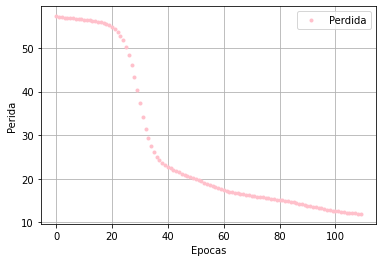

In [19]:
#ploteamos la perdida a traves de las epocas para los ultimos hiperparametros
plt.plot(np.arange(perdidas.size), perdidas, '.', label='Perdida', color = 'pink')
plt.legend()
plt.xlabel('Epocas')
plt.ylabel('Perida')
plt.grid(True)
plt.show()

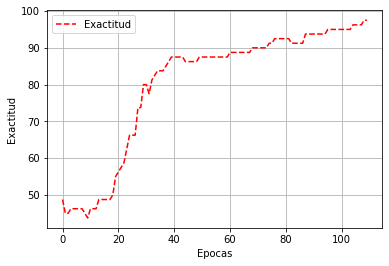

In [20]:
#ploteamos la exactitud a traves de las epocas para los ultimos hiperparametros
plt.plot(np.arange(exactitudes.size), exactitudes, '--', label='Exactitud', color='red')
plt.legend()
plt.xlabel('Epocas')
plt.ylabel('Exactitud')
plt.grid(True)
plt.show()

In [21]:
#validemos con nuestro conjunto de validacion
listaPredicciones = []
print('-----------------------------')
print('y\tprediccion')
print('-----------------------------')
for i in range(x_test.shape[0]):
    #calculamos la prediccion usando las W's y las b's con la funcion de propagacion
    #los valores de a2, z2 y z3 no se usan por eso tienen el nombre de foo
    foo1, foo2, foo3, foo4, foo5, prediccionDespuesdeEntrenar = propagacion(x_test[i],W1,b1,W2,b2, W3, b3)
    print('{0}\t{1}'.format(y_test[i], np.round(prediccionDespuesdeEntrenar[0,0])))
    listaPredicciones.append(prediccionDespuesdeEntrenar[0,0])
listaPredicciones = np.round(listaPredicciones)
print('La exactitud para los datos de test es de {0}'.format((y_test==listaPredicciones).mean()*100))

-----------------------------
y	prediccion
-----------------------------
1.0	1.0
0.0	1.0
0.0	1.0
1.0	1.0
1.0	1.0
0.0	0.0
1.0	1.0
1.0	1.0
0.0	0.0
1.0	1.0
1.0	1.0
0.0	0.0
1.0	1.0
1.0	1.0
0.0	0.0
1.0	1.0
1.0	1.0
0.0	0.0
1.0	1.0
0.0	0.0
La exactitud para los datos de test es de 90.0
